In [1]:
import pickle
import numpy as np
import pandas as pd
from keras.models import Sequential, load_model
from keras.layers import LSTM, Dense, LSTM, Dropout, Bidirectional, RepeatVector
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.regularizers import L1L2
from keras.utils import plot_model
import keras.backend as k
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

Using TensorFlow backend.
/home/kaush/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/kaush/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/kaush/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/kaush/.local/lib/python3.6/site-packages/tensorflow/python/fra

In [51]:
df = pickle.load(open('./dumps/df.pkl', 'rb'))
df.month = np.sin(2*np.pi/12*df.month)
df

,visibility,dew_pt,QFE,LC,TC,DRY,RH,WET,month
2016-01-01 05:45:00,6.0,7.4,927.0,1,1,8.7,92.0,8.0,5.000000e-01
2016-01-01 08:45:00,7.0,8.4,929.3,4,6,10.2,89.0,9.2,5.000000e-01
2016-01-01 11:45:00,9.0,7.8,930.0,2,2,17.6,54.0,12.2,5.000000e-01
2016-01-01 14:45:00,8.0,8.8,927.0,1,3,20.8,46.0,14.0,5.000000e-01
2016-01-01 17:45:00,7.0,10.3,927.3,1,2,16.4,67.0,12.9,5.000000e-01
2016-01-02 05:45:00,6.0,7.9,927.3,1,1,8.6,95.0,8.2,5.000000e-01
2016-01-02 08:45:00,7.0,8.8,929.1,1,1,10.2,91.0,9.4,5.000000e-01
2016-01-02 11:45:00,7.0,8.7,928.4,1,1,18.5,53.0,12.8,5.000000e-01
2016-01-02 14:45:00,8.0,9.8,925.7,2,2,21.6,47.0,14.5,5.000000e-01
2016-01-02 17:45:00,7.0,10.2,924.6,1,1,16.7,66.0,13.0,5.000000e-01


### The number of days to look back to make predictions

In [3]:
LOOK_BACK = 35

### Create the data for training LSTM

In [4]:
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), :]
        dataX.append(a)
        dataY.append(dataset[i + look_back, :])
    return np.array(dataX), np.array(dataY)

### We need to scale the data, because some columns have values that are way greater than others

In [5]:
scaler = StandardScaler()
X = scaler.fit_transform(df)

In [6]:
X, y = create_dataset(X, look_back=LOOK_BACK)
X.shape, y.shape

((5444, 35, 9), (5444, 9))

In [34]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [44]:
X_train = X[:-500]
X_test = X[-500:]
y_train = y[:-500]
y_test = y[-500:]

In [35]:
k.clear_session()
model = Sequential()
model.add(Dropout(0.25, input_shape=(LOOK_BACK, 9), name='Input_Layer'))
model.add(LSTM(LOOK_BACK, return_sequences=True, name='LSTM_1'))
model.add(LSTM(LOOK_BACK, return_sequences=True, name='LSTM_2'))
model.add(Dropout(0.25))
model.add(LSTM(LOOK_BACK, return_sequences=True, name='LSTM_3'))
model.add(Dropout(0.25))
model.add(LSTM(LOOK_BACK, return_sequences=True, name='LSTM_4'))
model.add(LSTM(LOOK_BACK, return_sequences=False, name='LSTM_5'))
model.add(Dense(81, activation='tanh', name='FullyConnected_1'))
model.add(Dropout(0.25))
model.add(Dense(27, activation='relu', name='FullyConnected_2'))
model.add(Dropout(0.25))
model.add(Dense(9, name='Output'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input_Layer_input (InputLaye (None, 35, 9)             0         
_________________________________________________________________
Input_Layer (Dropout)        (None, 35, 9)             0         
_________________________________________________________________
LSTM_1 (LSTM)                (None, 35, 35)            6300      
_________________________________________________________________
LSTM_2 (LSTM)                (None, 35, 35)            9940      
_________________________________________________________________
dropout_1 (Dropout)          (None, 35, 35)            0         
_________________________________________________________________
LSTM_3 (LSTM)                (None, 35, 35)            9940      
_________________________________________________________________
dropout_2 (Dropout)          (None, 35, 35)            0         
__________

In [36]:
callbacks = [
    EarlyStopping(patience=25, restore_best_weights=True),
    ModelCheckpoint('./dumps/best-model.h5', save_best_only=True, period=5),
    ReduceLROnPlateau()
]
model.compile(loss='mse', optimizer='nadam')

In [37]:
model.fit(X_train, y_train, epochs=1000, batch_size=128, validation_split=0.2, callbacks=callbacks)

Train on 3484 samples, validate on 871 samples
Epoch 1/1000
3484/3484 [==============================] - 10s 3ms/step - loss: 0.7447 - val_loss: 0.5238
Epoch 2/1000
3484/3484 [==============================] - 7s 2ms/step - loss: 0.5889 - val_loss: 0.5393
Epoch 3/1000
3484/3484 [==============================] - 7s 2ms/step - loss: 0.5556 - val_loss: 0.4817
Epoch 4/1000
3484/3484 [==============================] - 6s 2ms/step - loss: 0.5415 - val_loss: 0.4718
Epoch 5/1000
3484/3484 [==============================] - 8s 2ms/step - loss: 0.5258 - val_loss: 0.4655
Epoch 6/1000
3484/3484 [==============================] - 12s 3ms/step - loss: 0.5197 - val_loss: 0.4707
Epoch 7/1000
3484/3484 [==============================] - 7s 2ms/step - loss: 0.5102 - val_loss: 0.4580
Epoch 8/1000
3484/3484 [==============================] - 6s 2ms/step - loss: 0.5032 - val_loss: 0.4846
Epoch 9/1000
3484/3484 [==============================] - 8s 2ms/step - loss: 0.5006 - val_loss: 0.4470
Epoch 10/1000
3

# Accuracy of the model

In [13]:
def accuracy(actual, pred, confidence=1):
    return f'{format(np.mean((actual - pred) < confidence) * 100, ".2f")}%'

In [14]:
accuracy(y_train, model.predict(X_train), confidence=0.5)

'90.72%'

In [15]:
y_test_pred = model.predict(X_test)

In [16]:
accuracy(y_test, y_test_pred, confidence=1)

'97.58%'

In [17]:
accuracy(y_test, y_test_pred, confidence=0.5)

'90.31%'

In [18]:
accuracy(y_test, y_test_pred, confidence=0.25)

'78.50%'

### Save the model

In [38]:
model.save('./dumps/best-model.h5')

In [39]:
pickle.dump(model.history, open('./dumps/history.pkl', 'wb'))

### Load the model, if it has been previously trained

In [40]:
model = load_model('./dumps/best-model.h5')
history = pickle.load(open('./dumps/history.pkl', 'rb'))

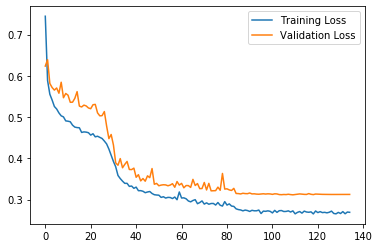

In [41]:
train_loss = history.history['loss']
val_loss = history.history['val_loss']

plt.plot(train_loss, label='Training Loss')
plt.plot([i+0.1 for i in val_loss], label='Validation Loss')
plt.legend()

# The model has been trained, get predictions for the test set

### Predicted values

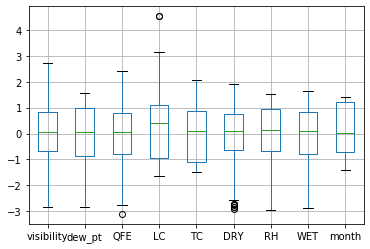

In [42]:
pd.DataFrame(y_test, columns=df.columns).boxplot()

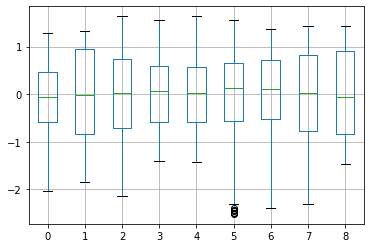

In [43]:
pd.DataFrame(model.predict(X_test)).boxplot()

In [45]:
preds = model.predict(X_test)
predictions = pd.DataFrame(scaler.inverse_transform(preds), columns=df.columns, index=df.tail(len(X_test)).index)
predictions = predictions.drop('month', axis=1)
predictions.index = pd.MultiIndex.from_arrays([predictions.index.date, predictions.index.time], names=['Date','Time'])
predictions = predictions.unstack().reset_index().set_index('Date')
for col in predictions:
    predictions[col] = predictions[col].map('{:,.1f}'.format).astype(float).dropna()
predictions

visibility                                       dew_pt           \
Time         05:45:00 08:45:00 11:45:00 14:45:00 17:45:00 05:45:00 08:45:00   
Date                                                                          
2018-09-23        6.7      5.5      7.4      9.3      9.4     20.9     19.8   
2018-09-24        7.5      5.3      7.1      8.8      9.2     21.0     19.8   
2018-09-25        6.8      4.8      5.6      7.9      8.8     21.6     20.4   
2018-09-26        6.1      4.1      5.2      7.2      8.3     21.5     20.8   
2018-09-27        7.8      4.9      6.2      8.3      8.8     21.6     20.1   
...               ...      ...      ...      ...      ...      ...      ...   
2018-12-27        8.2      5.9      7.0      9.1      9.3     10.5      8.9   
2018-12-28        8.3      6.1      8.4      9.6      9.6      9.9      8.3   
2018-12-29        9.5      7.0      9.1     10.0     10.2      9.1      7.1   
2018-12-30        9.8      7.2      9.6     10.3     10.6      8.9      6.8   
2018-12-31       10.2      7.3      9.8     10.4     10.8      9.3      7.1   

                                       ...       RH                    \
Time       11:45:00 14:45:00 17:45:00  ... 05:45:00 08:45:00 11:45:00   
Date                                   ...                              
2018-09-23     20.0     20.6     21.2  ...     83.4     89.2     78.0   
2018-09-24     20.2     21.1     21.6  ...     80.3     91.2     79.4   
2018-09-25     20.6     21.1     21.6  ...     83.3     93.4     85.4   
2018-09-26     20.8     21.4     21.9  ...     85.8     94.7     86.6   
2018-09-27     20.3     21.1     21.7  ...     77.9     92.7     82.6   
...             ...      ...      ...  ...      ...      ...      ...   
2018-12-27      9.4      9.6      9.3  ...     69.6     94.4     90.0   
2018-12-28      8.4      8.8      8.7  ...     67.9     94.7     87.5   
2018-12-29      7.6      8.0      8.1  ...     62.8     93.8     85.7   
2018-12-30      7.3      7.9      8.4  ...     62.2     93.8     84.1   
2018-12-31      7.4      8.1      8.7  ...     61.9     93.9     83.1   

                                  WET                                      
Time       14:45:00 17:45:00 05:45:00 08:45:00 11:45:00 14:45:00 17:45:00  
Date                                                                       
2018-09-23     67.6     66.9     21.9     20.4     21.3     22.7     23.4  
2018-09-24     69.1     67.6     22.1     20.2     21.4     23.1     23.7  
2018-09-25     72.7     69.1     22.5     20.7     21.4     22.8     23.6  
2018-09-26     76.0     72.0     22.3     21.0     21.5     22.9     23.6  
2018-09-27     70.8     68.4     22.9     20.5     21.3     22.9     23.8  
...             ...      ...      ...      ...      ...      ...      ...  
2018-12-27     63.7     53.3     13.2      9.6     10.3     12.8     13.7  
2018-12-28     60.0     50.9     12.8      8.9      9.5     12.5     13.3  
2018-12-29     56.8     47.7     12.4      7.6      8.8     12.1     13.1  
2018-12-30     55.2     46.2     12.3      7.4      8.6     12.2     13.5  
2018-12-31     54.4     44.8     12.7      7.5      8.8     12.4     14.0  

[100 rows x 40 columns]

### Actual Values

In [46]:
actual = df.tail(len(X_test))
actual.index = pd.MultiIndex.from_arrays([actual.index.date, actual.index.time], names=['Date','Time'])
actual = actual.drop('month', axis=1)
actual = actual.unstack().reset_index().set_index('Date').dropna()
actual

visibility                                       dew_pt           \
Time         05:45:00 08:45:00 11:45:00 14:45:00 17:45:00 05:45:00 08:45:00   
Date                                                                          
2018-09-23        6.0      8.0     10.0     10.0      8.0     20.1     21.2   
2018-09-24        5.0      6.0     10.0     10.0      5.0     20.7     20.3   
2018-09-25        2.0      5.0      7.0      8.0      7.0     21.8     22.1   
2018-09-26        3.0      3.0      6.0      9.0      9.0     20.5     22.2   
2018-09-27        6.0      6.0      6.0     10.0     10.0     20.0     20.8   
...               ...      ...      ...      ...      ...      ...      ...   
2018-12-27        7.0     10.0     10.0     10.0     10.0      7.2      7.0   
2018-12-28        6.0      7.0      8.0     10.0     10.0      5.3      6.8   
2018-12-29        6.0     10.0     10.0     10.0     10.0      4.1      5.7   
2018-12-30        7.0     10.0     10.0     10.0     10.0      4.4      5.6   
2018-12-31        7.0     10.0     10.0     10.0     10.0      4.6      5.4   

                                       ...       RH                    \
Time       11:45:00 14:45:00 17:45:00  ... 05:45:00 08:45:00 11:45:00   
Date                                   ...                              
2018-09-23     22.0     22.3     22.0  ...     97.0     82.0     70.0   
2018-09-24     23.5     22.4     21.8  ...     89.0     78.0     70.0   
2018-09-25     22.8     23.0     23.0  ...     96.0     90.0     70.0   
2018-09-26     22.0     22.4     22.7  ...     90.0     91.0     75.0   
2018-09-27     22.5     22.0     21.9  ...     90.0     82.0     75.0   
...             ...      ...      ...  ...      ...      ...      ...   
2018-12-27      6.6      7.2      6.3  ...     94.0     88.0     53.0   
2018-12-28      7.3      6.8      8.6  ...     92.0     90.0     61.0   
2018-12-29      6.5      6.6      8.7  ...     89.0     86.0     55.0   
2018-12-30      6.6      6.4      9.3  ...     94.0     89.0     54.0   
2018-12-31      6.5      7.2      7.8  ...     95.0     84.0     53.0   

                                  WET                                      
Time       14:45:00 17:45:00 05:45:00 08:45:00 11:45:00 14:45:00 17:45:00  
Date                                                                       
2018-09-23     64.0     73.0     20.2     22.2     23.8     24.5     23.5  
2018-09-24     72.0     90.0     21.3     21.5     25.2     24.0     22.4  
2018-09-25     69.0     81.0     22.0     22.7     24.6     24.7     24.0  
2018-09-26     63.0     72.0     21.0     22.7     23.4     24.6     24.2  
2018-09-27     61.0     73.0     20.6     21.8     23.8     24.3     23.4  
...             ...      ...      ...      ...      ...      ...      ...  
2018-12-27     48.0     60.0      7.7      8.0     11.2     12.4      9.8  
2018-12-28     50.0     70.0      6.0      7.6     10.8     12.0     11.3  
2018-12-29     45.0     68.0      5.4      6.8     11.0     12.3     11.4  
2018-12-30     40.0     67.0      4.8      6.6     11.2     12.8     12.1  
2018-12-31     42.0     60.0      5.0      6.7     11.2     13.2     11.4  

[100 rows x 40 columns]

# Visualize the predictions

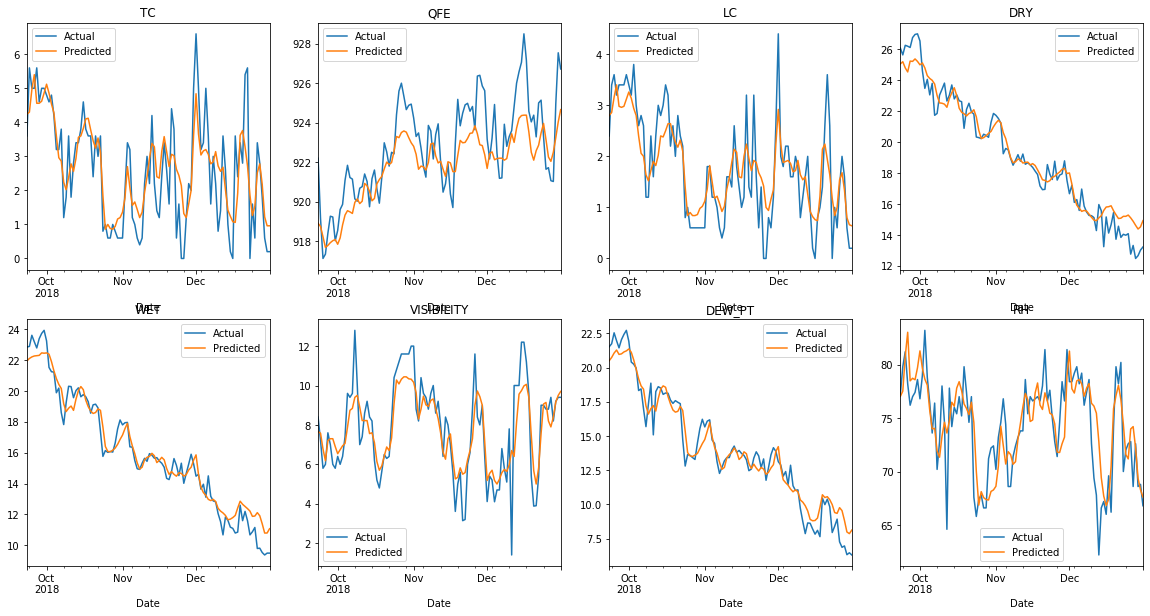

In [47]:
columns = list(set(actual.columns.get_level_values(0)))
columns
fig, ax_array = plt.subplots(2, 4, figsize=(20, 10))
for i in range(2):
    for j in range(4):
        title = columns[4*i+j]
        ax = actual[(title,)].mean(axis=1).plot(kind='line', ax=ax_array[i][j], title=title.upper())
        ax = predictions[(title,)].mean(axis=1).plot(kind='line', ax=ax_array[i][j], title=title.upper())
        ax.legend(['Actual', 'Predicted'])

# Actual Data Statistics

In [48]:
actual_df = actual.stack().reset_index().set_index('Date')
df = actual_df.resample('D')
actual_data_stats = df.mean().describe().iloc[1:,:]
actual_data_stats

,DRY,LC,QFE,RH,TC,WET,dew_pt,visibility
mean,19.204800,1.772000,922.79440,74.230000,2.61800,16.027000,14.035260,7.836800
std,3.917883,1.068188,2.40699,4.540936,1.65098,3.855346,4.267352,2.426067
min,12.480000,0.000000,917.12000,62.200000,0.00000,9.380000,6.300000,1.400000
25%,15.935000,0.950000,921.12500,71.350000,1.15000,13.165000,11.435000,6.000000
50%,18.770000,1.600000,922.87000,75.100000,2.70000,15.630000,13.580000,8.200000
75%,22.200000,2.600000,924.70000,77.650000,3.60000,19.110000,17.365000,9.450000
max,26.980000,4.400000,928.50000,83.200000,6.60000,23.920000,22.720000,12.800000


# Prediction Data Statistics

In [49]:
pred_df = predictions.stack().reset_index().set_index('Date')
df = pred_df.resample('D')
predicted_data_stats = df.mean().describe().iloc[1:,:]
predicted_data_stats

,DRY,LC,QFE,RH,TC,WET,dew_pt,visibility
mean,19.365000,1.777400,921.830200,74.449800,2.70220,16.164000,14.140400,7.717200
std,3.409611,0.695409,1.746328,3.828702,1.16662,3.393076,3.745364,1.600788
min,14.380000,0.640000,917.680000,66.820000,0.86000,10.800000,7.860000,5.000000
25%,15.815000,1.210000,921.070000,71.735000,1.75000,12.980000,11.105000,6.365000
50%,18.690000,1.720000,922.180000,75.060000,2.72000,15.700000,13.620000,7.570000
75%,22.105000,2.240000,923.025000,77.345000,3.54500,18.765000,16.925000,9.095000
max,25.360000,3.400000,924.660000,83.020000,5.40000,22.460000,21.360000,10.440000


In [120]:
days = LOOK_BACK
new_data = X_test[-1].tolist()
for i in range(days):
    for j in range(5):
        prediction = model.predict(np.array(new_data).reshape(1, 35, 9))
        new_data.pop(0)
        new_data.append(prediction.tolist()[0])
    

In [121]:
result = pd.DataFrame(np.delete(scaler.inverse_transform(np.array(new_data)), 8, 1).reshape(-1, 40))
result.columns = actual.columns
result.index = pd.date_range(start='1/1/2019', periods=7)
result

visibility                                               dew_pt  \
Time         05:45:00  08:45:00    11:45:00  14:45:00  17:45:00   05:45:00   
2019-01-01   9.676018  8.954945  921.487348  1.313031  1.982914  21.041578   
2019-01-02   9.713108  8.924844  921.478453  1.306477  1.971912  21.022850   
2019-01-03   9.755315  8.890761  921.499474  1.295189  1.951914  21.017099   
2019-01-04   9.800258  8.861467  921.544477  1.283141  1.929890  21.030314   
2019-01-05   9.832523  8.848547  921.590671  1.277129  1.918737  21.050831   
2019-01-06   9.846328  8.850337  921.628303  1.277317  1.919042  21.069265   
2019-01-07   9.848997  8.858473  921.662422  1.279687  1.923155  21.089051   

                                                      ...         RH  \
Time         08:45:00   11:45:00  14:45:00  17:45:00  ...   05:45:00   
2019-01-01  47.314904  13.974503  9.314152  9.841950  ...  83.506535   
2019-01-02  47.257531  13.949793  9.348228  9.807092  ...  83.405925   
2019-01-03  47.135059  13.928102  9.388595  9.768322  ...  83.259227   
2019-01-04  46.958017  13.916651  9.424942  9.742565  ...  83.118016   
2019-01-05  46.817637  13.917639  9.442907  9.737890  ...  83.024538   
2019-01-06  46.745683  13.926458  9.444017  9.745661  ...  82.965705   
2019-01-07  46.697252  13.939452  9.439043  9.756199  ...  82.912613   

                                                           WET            \
Time        08:45:00  11:45:00  14:45:00    17:45:00  05:45:00  08:45:00   
2019-01-01  9.986284  9.541818  8.865158  923.590869  1.103409  1.763139   
2019-01-02  9.969304  9.587670  8.835663  923.575588  1.094591  1.748170   
2019-01-03  9.946096  9.633385  8.798894  923.595821  1.083512  1.728835   
2019-01-04  9.936483  9.665359  8.773919  923.633329  1.078456  1.719983   
2019-01-05  9.944725  9.676613  8.767031  923.672580  1.080766  1.724104   
2019-01-06  9.959326  9.673740  8.769404  923.711877  1.085417  1.732182   
2019-01-07  9.972676  9.664865  8.774472  923.751361  1.089350  1.738676   

                                             
Time         11:45:00   14:45:00   17:45:00  
2019-01-01  18.080389  57.790327  12.794831  
2019-01-02  18.077766  57.671700  12.777183  
2019-01-03  18.083556  57.496962  12.758868  
2019-01-04  18.094633  57.351719  12.749244  
2019-01-05  18.105143  57.283126  12.749533  
2019-01-06  18.115400  57.255602  12.754898  
2019-01-07  18.129094  57.228409  12.763047  

[7 rows x 40 columns]